In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score

In [3]:
df = pd.read_csv("equipment_anomaly_data.csv", sep = ',')

In [4]:
df.head()

,temperature,pressure,vibration,humidity,equipment,location,faulty
0,58.180180,25.029278,0.606516,45.694907,Turbine,Atlanta,0.0
1,75.740712,22.954018,2.338095,41.867407,Compressor,Chicago,0.0
2,71.358594,27.276830,1.389198,58.954409,Turbine,San Francisco,0.0
3,71.616985,32.242921,1.770690,40.565138,Pump,Atlanta,0.0
4,66.506832,45.197471,0.345398,43.253795,Pump,New York,0.0


In [5]:
df.isnull().sum()

temperature    0
pressure       0
vibration      0
humidity       0
equipment      0
location       0
faulty         0
dtype: int64

In [6]:
df['faulty'] = df['faulty'].astype(int) # Float tipindeydi. Siniflandirma modellerinde daha rahat kullanilabilmek icin tip donusumu yaptik.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  7672 non-null   float64
 1   pressure     7672 non-null   float64
 2   vibration    7672 non-null   float64
 3   humidity     7672 non-null   float64
 4   equipment    7672 non-null   object 
 5   location     7672 non-null   object 
 6   faulty       7672 non-null   int32  
dtypes: float64(4), int32(1), object(2)
memory usage: 389.7+ KB


In [8]:
# Sutun Ozelliklerinin Incelenmesi
output_data = []
for col in df.columns: # Tum sutunlari inceliyor.

    if df.loc[:, col].nunique() <= 5: 
        """ Eger o sutunda en fazla 5 farkli deger varsa o zaman o sutunun tam olarak hangi degerleri aldgini
            listelemeye karar veriyor. 
            Mesela Fault Label sadece 2 farkli deger aliyor (0 ve 1), ama Temperature binlerce farkli deger aliyor. """
        
        unique_values = df.loc[:, col].unique()
        """ Eger bir sutundaki farkli deger sayisi ≤ 5 ise, tam olarak hangi degerler oldugunu listeledi. 
            Cunku bu sutun muhtemelen kategorik, Fault Label: 0,1 gibi. """

        output_data.append([col, df.loc[:, col].nunique(), unique_values, df.loc[:, col].dtype])
        """ Cektigi degerleri bos listeye ekliyor. Boylece gereksiz yere yuzlerce unique degeri listelemiyor.
            Ornegin; sicaklikta binlerce farkli deger var, onlari yazmaz. """

    else:
        output_data.append([col, df.loc[:, col].nunique(),"-", df.loc[:, col].dtype])
output_df = pd.DataFrame(output_data, columns = ['Column Name', 'Number of Unique Values', ' Unique Values ', 'Data Type'])
output_df

,Column Name,Number of Unique Values,Unique Values,Data Type
0,temperature,7672,-,float64
1,pressure,7672,-,float64
2,vibration,7672,-,float64
3,humidity,7672,-,float64
4,equipment,3,"[Turbine, Compressor, Pump]",object
5,location,5,"[Atlanta, Chicago, San Francisco, New York, Ho...",object
6,faulty,2,"[0, 1]",int32


In [9]:
df.describe() # Istatiksel Analiz

,temperature,pressure,vibration,humidity,faulty
count,7672.000000,7672.000000,7672.000000,7672.000000,7672.000000
mean,70.922478,35.738048,1.611809,50.016574,0.099974
std,16.200059,10.381593,0.728560,11.841479,0.299985
min,10.269385,3.620798,-0.428188,10.215077,0.000000
25%,62.777057,29.485682,1.170906,42.612817,0.000000
50%,70.156900,35.227544,1.533113,50.024744,0.000000
75%,77.568387,41.159913,1.924700,57.340513,0.000000
max,149.690420,79.887734,4.990537,89.984718,1.000000


In [10]:
""" count: Tum degiskenlerde 7672 gozlem var, yani veri setinde 7672 satir bulunuyor.
    faulty: Anomali
    mean = 0.099974: Yani verilerin yaklasik %10’u anomali (1), %90’i ise normal (0).
    std = 0.299985: Sinif dengesizligi yuksek, anomali ornekleri azinlikta.
    min/max = 0 ve 1: Etiketler dogru sekilde, binary.

    Tum ozelliklerde medyan ile ortalama birbirine yakin, ancak min ve max degerler arasi fark buyuk. 
    Bu, veri setinde uç degerlerin bulundugunu gosterir. Ozellikle anomali tespitinde, bu uc degerler modelin ogrenmesi 
    icin kritik oneme sahiptir. """

df['faulty'].value_counts()

""" faulty etiketinin sinif dagilimi incelendi:
    Sınıf 0 (Normal): 6907 Ornek
    Sınıf 1 (Anomali): 765 Ornek
    Bu, ciddi bir sinif dengesizligi oldugunu gosterir. Bu tur veri setlerinde modelin anomali sinifini ogrenmesi zor olabilir.
    Bu durum daha sonra kullanilacak olan modellerde dikkatle ele alinacaktır. Ornegin: class_weight = 'balanced' gibi 
    parametreler kullanilacak."""

" faulty etiketinin sinif dagilimi incelendi:\n    Sınıf 0 (Normal): 6907 Ornek\n    Sınıf 1 (Anomali): 765 Ornek\n    Bu, ciddi bir sinif dengesizligi oldugunu gosterir. Bu tur veri setlerinde modelin anomali sinifini ogrenmesi zor olabilir.\n    Bu durum daha sonra kullanilacak olan modellerde dikkatle ele alinacaktır. Ornegin: class_weight = 'balanced' gibi \n    parametreler kullanilacak."

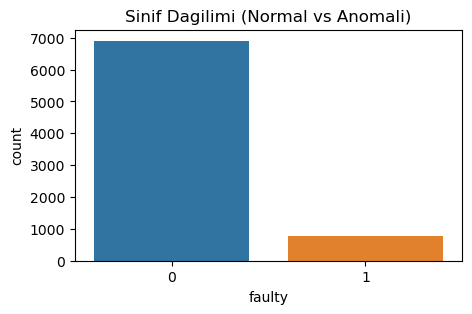

" Normal orneklerin (0) sayisi, anomalilere (1) gore cok daha fazla. Veri setinde dengesizlik var; bu, modelin egitimi \n    sirasında dikkate alinmasi gereken bir durum. Bu yuzden Random Forest modelinde class_weight = 'balanced' parametresi\n    kullanildi.\n\n    F1-score, dengesiz veri setlerinde dogruluk (accuracy) yerine daha anlamli bir metriktir. Bu anomali tespiti yapilirken\n    hem precision hem de recall dikkate alindi."

In [11]:
# Sinif Dagilimi
plt.figure(figsize = (5,3))
sns.countplot(x = 'faulty', data = df)
plt.title('Sinif Dagilimi (Normal vs Anomali)')
plt.show()

""" Normal orneklerin (0) sayisi, anomalilere (1) gore cok daha fazla. Veri setinde dengesizlik var; bu, modelin egitimi 
    sirasında dikkate alinmasi gereken bir durum. Bu yuzden Random Forest modelinde class_weight = 'balanced' parametresi
    kullanildi.

    F1-score, dengesiz veri setlerinde dogruluk (accuracy) yerine daha anlamli bir metriktir. Bu anomali tespiti yapilirken
    hem precision hem de recall dikkate alindi."""

c:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


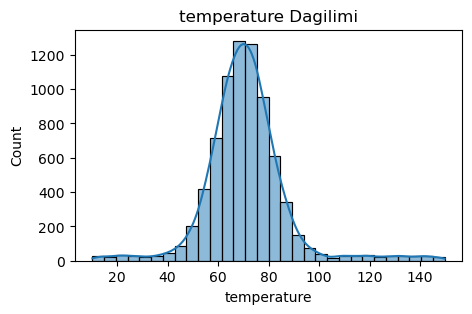

c:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


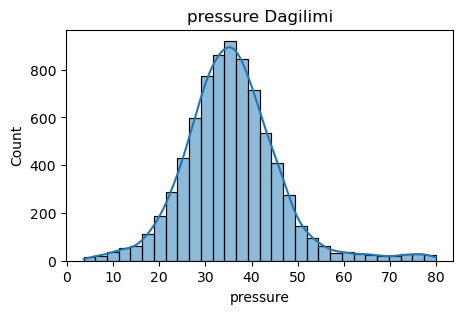

c:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


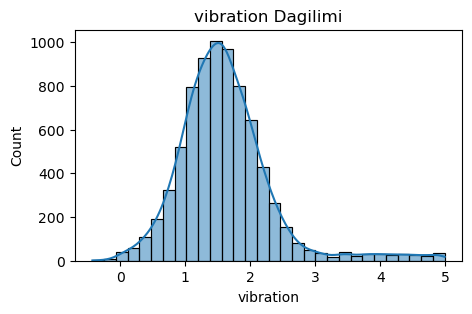

c:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


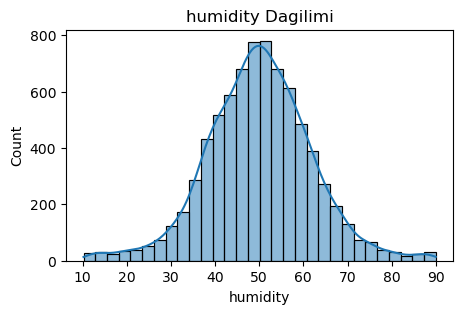

In [12]:
# Diger sutunlarin dagilimi inceleniyor.
num_cols = ['temperature', 'pressure', 'vibration', 'humidity'] # Sayisal Featurelar
for col in num_cols:
    plt.figure(figsize = (5, 3))
    sns.histplot(df[col], kde = True, bins = 30)
    plt.title(f'{col} Dagilimi')
    plt.show()

c:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


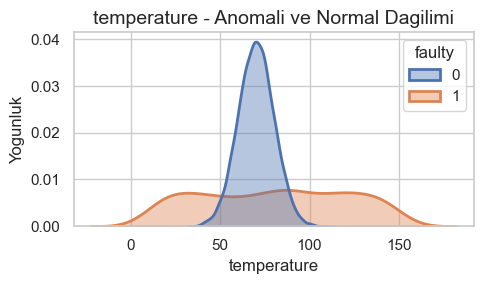

c:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


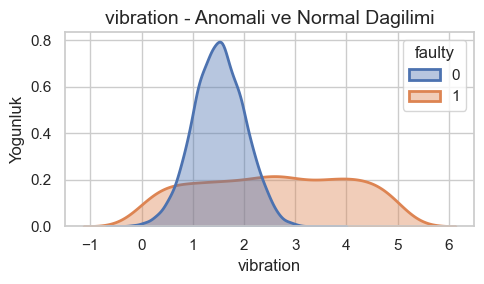

c:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


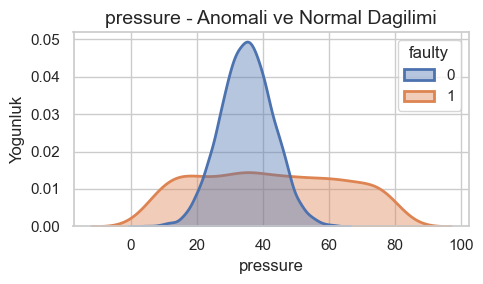

c:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


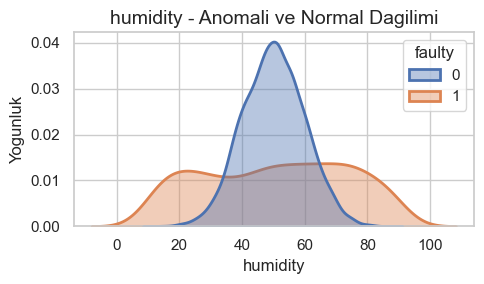

In [13]:
# Sayisal sutunlar tanimlaniyor.
num_cols = ['temperature', 'vibration', 'pressure', 'humidity']

# Seaborn Stili
sns.set(style = "whitegrid")

for col in num_cols:
    plt.figure(figsize = (5, 3))
    sns.kdeplot(
        data = df,
        x = col,
        hue = 'faulty',
        fill = True,
        common_norm = False,
        alpha = 0.4,
        linewidth = 2
    )
    plt.title(f'{col} - Anomali ve Normal Dagilimi', fontsize = 14)
    plt.xlabel(col)
    plt.ylabel("Yogunluk")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    """ Sayisal degiskenlerin anomali (faulty = 1) ve normal (faulty = 0) ornekler uzerindeki dagilimlarini karsilastirmali
        olarak analiz etmeyi saglar. 
        Anomali ve normal orneklerin dagilimlari arasinda farklar var.
        Ornegin, anomalilerde sicaklik veya titresim degerleri normalden farkli bir aralikta yogunlasmis. Bu, modelin
        bu ozellikleri kullanarak anomaliyi ayirt edebilecegini gosterir. """

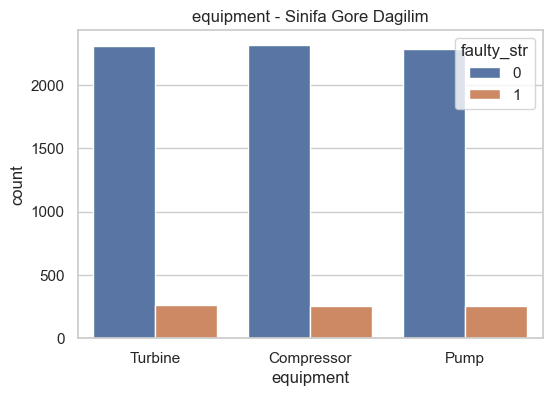

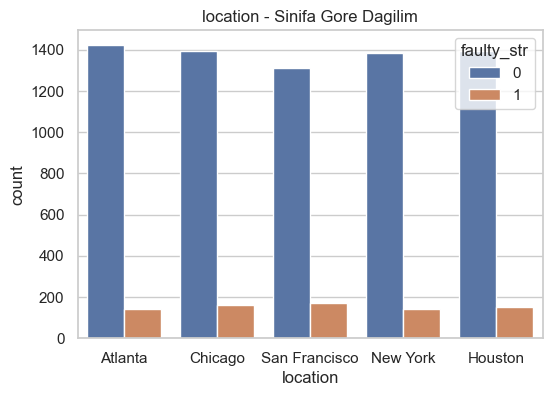

In [14]:
df['faulty_str'] = df['faulty'].astype(str)

# Kategorik Degiskenlerin Dagilimi
for col in ['equipment', 'location']:
    plt.figure(figsize = (6, 4))
    sns.countplot(x = col, hue = 'faulty_str', data = df)
    plt.title(f'{col} - Sinifa Gore Dagilim')
    plt.show()

    """ Ekipmanlar arasinda anomali orani neredeyse esit. Demek ki sistemin her bir parcası esit derecede riskli gibi 
        gozukuyor.

        equipment degiskeni anomali tahmini icin tek basina guclu bir ayrim saglamiyor olabilir.
        Anomalili (turuncu) kayitlar ise her sehirde benzer seviyede.
        Sehirler arasinda cok belirgin fark yok.
        location degiskeni de dogrudan anomaliyle ilisklendirilemeyebilir ama, lokasyona ozel modeller gelistirilecekse 
        faydali olabilir."""

In [15]:
""" Feature Engineering: Var olan degiskenlerden yeni, anlamli ozellikler cikariyorsun. 
    Her biri modelin anomali tespitinde daha iyi ogrenmesini saglayabilir. """
# Oranlar ve  Etkilesimler
df['temp_press_ratio'] = df['temperature'] / (df['pressure'] + 1e-3) # Sifira bolme hatasindan kacinilmis.
df['vib_hum_ratio'] = df['vibration'] / (df['humidity'] + 1e-3)
df['temp_vib_sum'] = df['temperature'] + df['vibration']

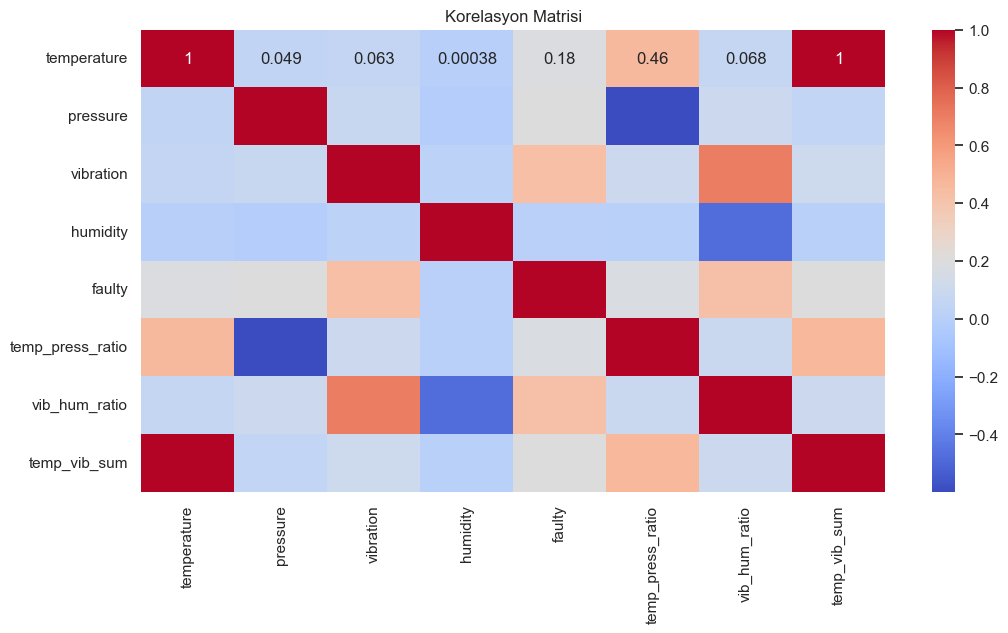

In [16]:
corr_cols = df.select_dtypes(include = [np.number]).columns # Sadece sayisal sutunlar seciliyor.
plt.figure(figsize = (12, 6))
sns.heatmap(df[corr_cols].corr(), annot = True, cmap = 'coolwarm')
plt.title('Korelasyon Matrisi')
plt.show()

In [17]:
# Label Encoding
for col in ['equipment', 'location']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [18]:
df.head()

,temperature,pressure,vibration,humidity,equipment,location,faulty,faulty_str,temp_press_ratio,vib_hum_ratio,temp_vib_sum
0,58.180180,25.029278,0.606516,45.694907,2,0,0,0,2.324392,0.013273,58.786696
1,75.740712,22.954018,2.338095,41.867407,0,1,0,0,3.299528,0.055844,78.078807
2,71.358594,27.276830,1.389198,58.954409,2,4,0,0,2.615992,0.023564,72.747793
3,71.616985,32.242921,1.770690,40.565138,1,0,0,0,2.221100,0.043649,73.387675
4,66.506832,45.197471,0.345398,43.253795,1,3,0,0,1.471440,0.007985,66.852230


In [19]:
# Modellemeye Hazirlik
feature_cols = ['temperature', 'pressure', 'vibration', 'humidity', 'equipment', 'location']
X = df[feature_cols]
y = df['faulty']

In [20]:
y
# location, humidity, equipment kullanmasak da olur cunku korelasyonu az ve modele cok fazla katkisi yok.

0       0
1       0
2       0
3       0
4       0
       ..
7667    0
7668    0
7669    0
7670    1
7671    1
Name: faulty, Length: 7672, dtype: int32

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [22]:
# Scaled Data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
# z-Score Standardizasyonu: Her sayisal sutun icin ortalama 0, standart sapma 1 olacak sekilde yeniden olceklendirmektir.
for col in num_cols:
    mean = X_train[col].mean()
    std = X_train[col].std() # Standart Sapma
    X_train[f'{col}_zscore'] = (X_train[col] - mean) / std 
    # Egitim setinde z-score hesaplanip yeni bir sutun olarak ekleniyor.
    X_test[f'{col}_zscore'] = (X_test[col] - mean) / std 
    """ Ayni ortalama ve standart sapma ile test setine uygulaniyor. (Test setini normalize ederken train ortalamasi ve 
    standrat sapmasi kullanilir!!! """ 


In [24]:
# z-Score Feature'larini Ekle
zscore_cols = [f'{col}_zscore' for col in num_cols]
X_train_full = np.hstack([X_scaled, X_train[zscore_cols].values])
X_test_full = np.hstack([X_test_scaled, X_test[zscore_cols].values])

""" Bu kodlar, sayisal degiskenlerin standart skorlarini (z-score) hesaplayip, bunlari modele ek ozellik olarak dahil eder.
    Amac, modelin verideki sapmalari ve uc degerleri daha iyi ogrenmesini saglamaktir. """

' Bu kodlar, sayisal degiskenlerin standart skorlarini (z-score) hesaplayip, bunlari modele ek ozellik olarak dahil eder.\n    Amac, modelin verideki sapmalari ve uc degerleri daha iyi ogrenmesini saglamaktir. '

In [25]:
pd.DataFrame(X_test_full)

,0,1,2,3,4,5,6,7,8,9
0,0.446736,0.339606,0.463379,0.708850,1.0,1.00,0.110949,0.632942,-0.599620,1.412358
1,0.393191,0.410698,0.244829,0.571839,0.0,0.50,-0.350570,-0.994250,-0.078628,0.484706
2,0.511824,0.276159,0.273981,0.577690,1.0,0.75,0.671949,-0.777206,-1.064584,0.524317
3,0.385107,0.196295,0.207969,0.581513,1.0,0.75,-0.420246,-1.268686,-1.649860,0.550204
4,0.483352,0.343790,0.278798,0.585995,0.5,0.50,0.426543,-0.741338,-0.568961,0.580550
...,...,...,...,...,...,...,...,...,...,...
1530,0.457813,0.330800,0.390733,0.672760,0.0,0.50,0.206423,0.092060,-0.664156,1.168006
1531,0.441639,0.510079,0.502907,0.467238,0.0,0.25,0.067010,0.927245,0.649671,-0.223514
1532,0.381810,0.517080,0.245891,0.469584,0.5,0.00,-0.448664,-0.986342,0.700981,-0.207636
1533,0.330470,0.458648,0.338455,0.413203,0.0,0.50,-0.891174,-0.297166,0.272762,-0.589368


In [26]:
# Random Forest (Supervised)
rf = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced', random_state = 42)
rf.fit(X_train_full, y_train)
y_pred = rf.predict(X_test_full)
print("RandomForest Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

RandomForest Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1382
           1       0.98      0.84      0.91       153

    accuracy                           0.98      1535
   macro avg       0.98      0.92      0.95      1535
weighted avg       0.98      0.98      0.98      1535

Confusion Matrix:
 [[1379    3]
 [  24  129]]


In [27]:
# Random Forest (Cross-Validation Ile)
# Ovetfitting riski azalir.
rf = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced', random_state = 42)
cv_scores = cross_val_score(rf, X_train_full, y_train, cv = 5, scoring = 'f1')
""" Burada model, cross_val_score fonksiyonu tarafindan 5 kez bastan olusturulup egitiliyor ve test ediliyor.
    Gecici, test icin olusturuluyor. """
print(f"RandomForest 5-fold CV F1-score: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

# Gercek Egitim
rf.fit(X_train_full, y_train)
y_pred = rf.predict(X_test_full)
print("RandomForest Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

""" Çıktı: Accuracy: %98 Anomali (1): Precision %97, Recall %86, Karisiklik Matrisi: 22 tane anomaliyi kacirmis, 4 tane normal ornegi ise yanlis
    anomali demis.
    Yorum: Model, normal ornekleri neredeyse tamamen dogru tahmin ediyor. Anomalilerde ise bazılarini kaciriyor, ama genel olarak basarili."""

RandomForest 5-fold CV F1-score: 0.898 (+/- 0.010)
RandomForest Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1382
           1       0.98      0.84      0.91       153

    accuracy                           0.98      1535
   macro avg       0.98      0.92      0.95      1535
weighted avg       0.98      0.98      0.98      1535

Confusion Matrix:
 [[1379    3]
 [  24  129]]


' Çıktı: Accuracy: %98 Anomali (1): Precision %97, Recall %86, Karisiklik Matrisi: 22 tane anomaliyi kacirmis, 4 tane normal ornegi ise yanlis\n    anomali demis.\n    Yorum: Model, normal ornekleri neredeyse tamamen dogru tahmin ediyor. Anomalilerde ise bazılarini kaciriyor, ama genel olarak basarili.'

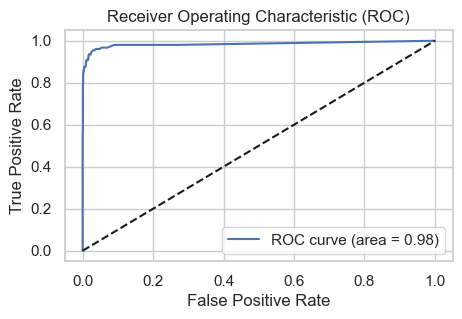

In [28]:
# ROC Curve
y_proba = rf.predict_proba(X_test_full)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize = (5,3))
plt.plot(fpr, tpr, label = f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()

# Altindaki alan buyuk oranda 1'e yakin oldugu icin modelin basarili oldugunu gosteriyor.

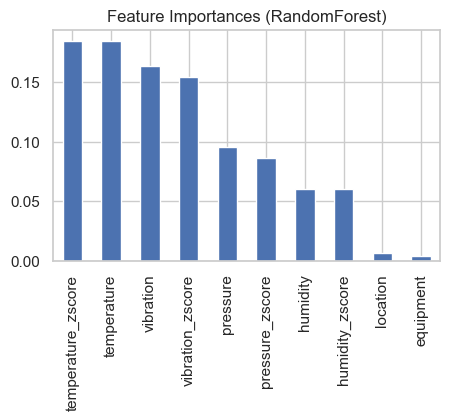

In [29]:
# Feature Importance: Bu kod, Random Forest modelindeki ozelliklerin onem derecelerini hesaplayip, gorsellestiriyor.
importances = rf.feature_importances_
all_feature_names = feature_cols + zscore_cols
feat_imp = pd.Series(importances, index = all_feature_names).sort_values(ascending = False)
plt.figure(figsize = (5, 3))
feat_imp.plot(kind = 'bar')
plt.title('Feature Importances (RandomForest)')
plt.show()

# Bu degerler, modelin o ozelligi karar vermede ne kadar kullandigini gosterir.
# Modelin hangi ozelliklere daha cok onem verdigini gorup, veri analizinde ve model iyilestirmede yol gosterir.